# Module Import

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
import torchvision.models as models

# Device

In [3]:
if torch.cuda.is_available() :
    DEVICE = torch.device('cuda')
else : 
    DEVICE = torch.device('cpu')
print('Using PyTorch version : ',torch.__version__ ,"Device : ",DEVICE )

Using PyTorch version :  1.11.0 Device :  cpu


# Parameter Set

In [4]:
BATCH_SIZE = 32
EPOCHS = 10

# Data Load

In [5]:
data_transforms = {
    'train' : transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
    ]),
    'val' : transforms.Compose([
        transforms.CenterCrop(224),
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
    ])
}

image_datasets = { x : datasets.ImageFolder("dogs-vs-cats", data_transforms[x]) for x in ['train','val'] 
}
dataloaders = {x : torch.utils.data.DataLoader(image_datasets[x],
batch_size = BATCH_SIZE,
num_workers= 0,
shuffle = True) for x in ['train','val']}

# Check Data  how label set?

In [8]:
for (X_train, y_train) in dataloaders['train']:
    print('X_train:',X_train.size(),'type:', X_train.type())
    print('y_train:',y_train.size(),'type:', y_train.type())
    break

X_train: torch.Size([32, 3, 224, 224]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

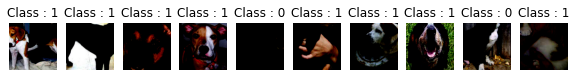

In [11]:
pltsize = 1
plt.figure(figsize=(10*pltsize,pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i],(1,2,0)))
    plt.title('Class : ' + str(y_train[i].item()))

# Model

In [17]:
model = models.resnet18(pretrained = True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs,2)
#model= model.cuda()

# Optmizer Objective

In [19]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# train

In [20]:
def train(model,train_loader,optimizer,log_interval):
    model.train()
    for batch_idx,(image,label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output,label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval ==0 :
            print("Train Epoch: {} [{}/{}({:.0f}%)] \t Train Loss : {:.6f}". format(EPOCHS,batch_idx*len(image),len(train_loader.dataset),100.*batch_idx/len(train_loader),loss.item()   ))


# 

# Evaluate

In [22]:
def evaluate(model,test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image,label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output,label).item()
            prediction = output.max(1,keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy